# Ensemble Modelling - Prudential Life

## Importing Packages and loading into DF

In [19]:
from __future__ import print_function
import timeit

from sklearn.model_selection import learning_curve, ShuffleSplit
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

%matplotlib inline

from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
import sklearn.ensemble
import xgboost as xgb
from sklearn.ensemble import ExtraTreesClassifier
# from imblearn.over_sampling import SMOTE

from sklearn.metrics import log_loss

import lime
import lime.lime_tabular

pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

In [2]:
ins_data = './dataset/train.csv'
ins = pd.read_csv(ins_data)
# ins_test_data = './dataset/test.csv'
# ins_test = pd.read_csv(ins_test_data)

In [3]:
print(ins.shape)
# print(ins_test.shape)

(59381, 128)


## Cleaing Data
- Dropping Axis Column
- Creating dummy for column Product_Info_2 column
- Removing NaN values - where normally distributed, replacing with mean value, where other columns used meadian.

In [4]:
ins.drop('Id',axis=1,inplace=True)
# ins_test.drop('Id',axis=1,inplace=True)

In [5]:
ins.Product_Info_2.value_counts()
prod_2 = {'A1':1,'A2':2,'A3':3,'A4':4,'A5':5,'A6':6,'A7':7,'A8':8,'B1':9,'B2':10,'C1':11,'C2':12,
          'C3':13,'C4':14,'D1':15,'D2':16,'D3':17,'D4':18,'E1':19}

ins.replace({"Product_Info_2": prod_2},inplace=True)

In [6]:
for i in range(2,6):
    ins['Family_Hist_%i' % i].fillna(0,inplace=True)
#     ins_test['Family_Hist_%i' % i].fillna(0,inplace=True)

for i in [1,10,15,24,32]:
    ins['Medical_History_%i' % i].fillna(0,inplace=True)
#     ins_test['Medical_History_%i' % i].fillna(0,inplace=True)

for i in [1,4,6]:
    ins['Employment_Info_%i' % i].fillna(0,inplace=True)
#     ins_test['Employment_Info_%i' % i].fillna(0,inplace=True)

ins['Insurance_History_5'].fillna(0,inplace=True)
# ins_test['Insurance_History_5'].fillna(0,inplace=True)

## Creating X and y for modelling

In [7]:
ins.head()

,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_10,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_15,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,Medical_History_24,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_30,Medical_History_31,Medical_History_32,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,1,17,10,0.076923,2,1,1,0.641791,0.581818,0.148536,0.323008,0.028,12,1,0.0,3,0.0000,1,2,6,3,1,2,1,1,1,3,1,0.000667,1,1,2,2,0.000000,0.598039,0.000000,0.526786,4.0,112,2,1,1,3,2,2,1,0.0,3,2,3,3,240.0,3,3,1,1,2,1,2,3,0.0,1,3,3,1,3,2,3,0.0,1,3,1,2,2,1,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
1,1,1,26,0.076923,2,3,1,0.059701,0.600000,0.131799,0.272288,0.000,1,3,0.0,2,0.0018,1,2,6,3,1,2,1,2,1,3,1,0.000133,1,3,2,2,0.188406,0.000000,0.084507,0.000000,5.0,412,2,1,1,3,2,2,1,0.0,3,2,3,3,0.0,1,3,1,1,2,1,2,3,0.0,1,3,3,1,3,2,3,0.0,3,1,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
2,1,19,26,0.076923,2,3,1,0.029851,0.745455,0.288703,0.428780,0.030,9,1,0.0,2,0.0300,1,2,8,3,1,1,1,2,1,1,3,0.000000,3,2,3,3,0.304348,0.000000,0.225352,0.000000,10.0,3,2,2,1,3,2,2,2,0.0,3,2,3,3,0.0,1,3,1,1,2,1,2,3,0.0,2,2,3,1,3,2,3,0.0,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
3,1,18,10,0.487179,2,3,1,0.164179,0.672727,0.205021,0.352438,0.042,9,1,0.0,3,0.2000,2,2,8,3,1,2,1,2,1,1,3,0.000000,3,2,3,3,0.420290,0.000000,0.352113,0.000000,0.0,350,2,2,1,3,2,2,2,0.0,3,2,3,3,0.0,1,3,1,1,2,2,2,3,0.0,1,3,3,1,3,2,3,0.0,3,3,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
4,1,16,26,0.230769,2,3,1,0.417910,0.654545,0.234310,0.424046,0.027,9,1,0.0,2,0.0500,1,2,6,3,1,2,1,2,1,1,3,0.000000,3,2,3,2,0.463768,0.000000,0.408451,0.000000,0.0,162,2,2,1,3,2,2,2,0.0,3,2,3,3,0.0,1,3,1,1,2,1,2,3,0.0,2,2,3,1,3,2,3,0.0,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8


In [8]:
#converting number to reduce size
for i in ins.columns:
    if str(ins[i].dtypes) == 'int64':
        ins[i] = ins[i].astype('int8')
    else:
        ins[i] = ins[i].astype('float16')

In [9]:
features = ins.drop(['Response','Ht','Wt'],axis=1)
targets = ins.Response
targets = targets.map(lambda x: x-1)
X, X_holdout, y, y_holdout = train_test_split(features,targets, train_size = 0.8,test_size=0.2,random_state=77)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.9,test_size=0.1,random_state=50)

In [10]:
int_col_num= []
int_col_name= []
flt_col_name = []
for i in range(0,len(X_train.columns)):
    if str(X_train.dtypes[i]) == 'int64':
        int_col_num.append(int(i))
        int_col_name.append(X_train.columns[i])
    else:
        flt_col_name.append(X_train.columns[i])

In [11]:
print(X_train.shape)

(42753, 124)


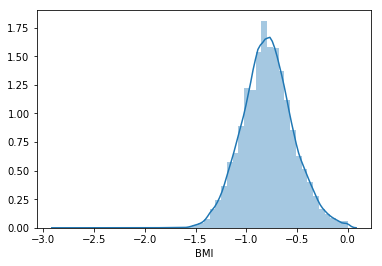

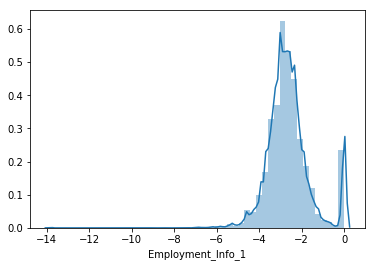

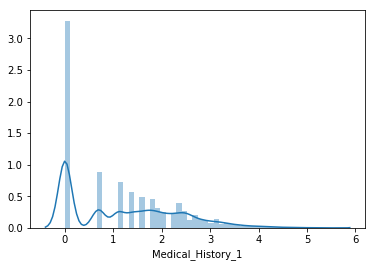

In [12]:
#trying out log transformation on the below 3 columns. This appeared to have minimal impact overall however.
i=1

for n in ['BMI', 'Employment_Info_1','Medical_History_1']:
    ins[n] = ins[n].apply(lambda x: np.log(x) if x !=0 else x)
    plt.figure(i)
    sns.distplot(ins[n])
    i += 1

#### Determining Baseline

In [13]:
y_train.value_counts()

7    14028
5     8069
6     5821
1     4714
0     4489
4     3906
3     1003
2      723
Name: Response, dtype: int64

In [14]:
baseline=15637/len(y_train)
print(baseline)

0.36575211096297333


## Logistic Regression

In [19]:
lr = LogisticRegression(multi_class='auto', solver = 'liblinear')

In [20]:
scores = cross_val_score(lr, X_train, y_train, cv=5,n_jobs=-1,verbose=1)
predictions = cross_val_predict(lr, X_train,y_train,cv=5,n_jobs=3)
r2 = metrics.r2_score(y_train, predictions)
print(scores)
print(scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


[0.49532383 0.49304338 0.49690095 0.49666628 0.49052188]
0.494491261460248


CV Results - (multi_class='auto', solver = 'liblinear')

[0.49590835 0.49397872 0.49923985 0.49584747 0.49075591]
0.4951460599227767

In [21]:
scores=cross_val_score(lr,X_train,y_train,cv=5,n_jobs=3)

In [22]:
accuracy_score_train = scores.mean()
lr.fit(X_train,y_train)
accuracy_score_test = lr.score(X_test,y_test)

y_pred = lr.predict_proba(X_test)
log_loss_test = log_loss(y_test,y_pred)

y_pred = lr.predict_proba(X_train)
log_loss_train = log_loss(y_train,y_pred)

print('baseline: ',baseline)
print('-------------------------------')
print("accuracy score - train: ",accuracy_score_train)
print("accuracy score - test: ",accuracy_score_test)
print('-------------------------------')
print("log loss score - train: ",log_loss_train)
print("log loss score - test: ",log_loss_test)

baseline:  0.36575211096297333
-------------------------------
accuracy score - train:  0.494491261460248
accuracy score - test:  0.4980004209640076
-------------------------------
log loss score - train:  1.366988536571226
log loss score - test:  1.384657443589925


In [23]:
y_train.value_counts(normalize=True)

7    0.328702
5    0.189624
6    0.136318
1    0.110144
0    0.102823
4    0.091081
3    0.024536
2    0.016771
Name: Response, dtype: float64

## Logistic Regression - Ridge

In [ ]:
lr_lasso = LogisticRegressionCV(penalty='l2', Cs=200, cv=5, solver='liblinear',multi_class='auto',n_jobs=3)
lr_lasso.fit(X_train, y_train)

In [ ]:
accuracy_score_train = lr_ridge.score(X_train,y_train)
accuracy_score_test = lr_ridge.score(X_test,y_test)

y_pred = lr_ridge.predict_proba(X_test)
log_loss_test = log_loss(y_test,y_pred)

y_pred = lr_ridge.predict_proba(X_train)
log_loss_train = log_loss(y_train,y_pred)

print('baseline: ',baseline)
print('-------------------------------')
print("accuracy score - train: ",accuracy_score_train)
print("accuracy score - test: ",accuracy_score_test)
print('-------------------------------')
print("log loss score - train: ",log_loss_train)
print("log loss score - test: ",log_loss_test)

## Logistic Regression - Lasso

In [ ]:
lr_lasso = LogisticRegressionCV(penalty='l1', solver='liblinear', Cs=200, cv=10)
lr_lasso.fit(X_train, y_train)

In [ ]:
accuracy_score_train = lr_lasso.score(X_train,y_train)
accuracy_score_test = lr_lasso.score(X_test,y_test)

y_pred = lr_lasso.predict_proba(X_test)
log_loss_test = log_loss(y_test,y_pred)

y_pred = lr_lasso.predict_proba(X_train)
log_loss_train = log_loss(y_train,y_pred)

print('baseline: ',baseline)
print('-------------------------------')
print("accuracy score - train: ",accuracy_score_train)
print("accuracy score - test: ",accuracy_score_test)
print('-------------------------------')
print("log loss score - train: ",log_loss_train)
print("log loss score - test: ",log_loss_test)

## SVM

In [ ]:
parameters = {'C':[0.001,0.25,0.5,0.75,1,10],
              'kernel':['linear','rbf'],
              'gamma':['scale',0.001,0.01,0.1,1,2,3],
              'decision_function_shape':['ovo','ovr']}

In [ ]:
svm = SVC(probability=True,random_state=42)
grid_search = GridSearchCV(svm,param_grid=parameters,cv=3,n_jobs=3)
grid_search.fit(X_train,y_train)

In [ ]:
grid_search.best_params_

In [18]:
svm = SVC(C=1, kernel='rbf', gamma='scale',decision_function_shape='ovr',probability=True,random_state=42)

In [19]:
scores = cross_val_score(svm, X_train, y_train, cv=5,n_jobs=-1,verbose=1)
predictions = cross_val_predict(svm, X_train,y_train,cv=5,n_jobs=3)
r2 = metrics.r2_score(y_train, predictions)
print(scores)
print(scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 64.1min remaining: 96.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 64.3min finished


[0.36029928 0.36244593 0.3573851  0.35466136 0.35490288]
0.35793890883976404


CV Scores - (cv=5,n_jobs=-1,verbose=1)

[0.36029928 0.36244593 0.3573851  0.35466136 0.35490288]
0.35793890883976404

In [ ]:
svm.fit(X_train,y_train)
accuracy_score_train = grid_search.best_score_

accuracy_score_test = grid_search.score(X_test,y_test)

y_pred = grid_search.predict_proba(X_test)
log_loss_test = log_loss(y_test,y_pred)

y_pred = grid_search.predict_proba(X_train)
log_loss_train = log_loss(y_train,y_pred)

print('baseline: ',baseline)
print('-------------------------------')
print("accuracy score - train: ",accuracy_score_train)
print("accuracy score - test: ",accuracy_score_test)
print('-------------------------------')
print("log loss score - train: ",log_loss_train)
print("log loss score - test: ",log_loss_test)

Test 1
- C=0.001, kernel='rbf', gamma='scale',decision_function_shape='ovr',probability=True,random_state=42

## Random Forest

In [15]:
forest = RandomForestClassifier(max_depth=5,max_leaf_nodes=30,verbose=1)

In [20]:
scores = cross_val_score(forest, X_train, y_train, cv=5,n_jobs=3,verbose=1)
predictions = cross_val_predict(forest, X_train,y_train,cv=5,n_jobs=3)
r2 = metrics.r2_score(y_train, predictions)
print(scores)
print(scores.mean())

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    5.1s finished


[0.44821136 0.45703262 0.41831365 0.43829688 0.46173648]
0.4447181984995579


CV Results (max_depth=5,max_leaf_nodes=30,class_weight='balanced',verbose=1)

[0.42646715 0.41190226 0.42673372 0.40905369 0.41048444]
0.4169282498796433

CV Results (max_depth=5,max_leaf_nodes=30,verbose=1)

[0.44201543 0.44557465 0.46099871 0.43853082 0.4678212 ]
0.4509881644734108

In [16]:
forest.fit(X_train,y_train)

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=30,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [22]:
accuracy_score_train = forest.score(X_train,y_train)

accuracy_score_test = forest.score(X_test,y_test)

y_pred = forest.predict_proba(X_test)
log_loss_test = log_loss(y_test,y_pred)

y_pred = forest.predict_proba(X_train)
log_loss_train = log_loss(y_train,y_pred)

print('baseline: ',baseline)
print('-------------------------------')
print("accuracy score - train: ",accuracy_score_train)
print("accuracy score - test: ",accuracy_score_test)
print('-------------------------------')
print("log loss score - train: ",log_loss_train)
print("log loss score - test: ",log_loss_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


baseline:  0.36575211096297333
-------------------------------
accuracy score - train:  0.46139452202184644
accuracy score - test:  0.46095558829720057
-------------------------------
log loss score - train:  1.4964091323898545
log loss score - test:  1.4962416907564446


In [ ]:
forest_features = pd.DataFrame()
forest_features['feature'] = X.columns
forest_features['importance'] = forest.feature_importances_
forest_features.sort_values('importance',ascending=False).head(10)

## XGBoost

In [15]:
model = XGBClassifier(learning_rate=0.01,max_depth= 7,eta= 0.1,verbosity= 1,objective= 'multi:softprob',num_class= 7,reg_lambda=0)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train,y_train,eval_metric=['merror','mlogloss'],eval_set=eval_set, verbose=True)

[0]	validation_0-merror:0.446425	validation_0-mlogloss:1.96987	validation_1-merror:0.443486	validation_1-mlogloss:1.97088
[1]	validation_0-merror:0.44432	validation_0-mlogloss:1.88228	validation_1-merror:0.441591	validation_1-mlogloss:1.88458
[2]	validation_0-merror:0.442144	validation_0-mlogloss:1.81038	validation_1-merror:0.441591	validation_1-mlogloss:1.81396
[3]	validation_0-merror:0.443688	validation_0-mlogloss:1.74866	validation_1-merror:0.441381	validation_1-mlogloss:1.75383
[4]	validation_0-merror:0.442144	validation_0-mlogloss:1.69555	validation_1-merror:0.445169	validation_1-mlogloss:1.70229
[5]	validation_0-merror:0.440952	validation_0-mlogloss:1.6491	validation_1-merror:0.446853	validation_1-mlogloss:1.65723
[6]	validation_0-merror:0.439478	validation_0-mlogloss:1.60783	validation_1-merror:0.44538	validation_1-mlogloss:1.61735
[7]	validation_0-merror:0.437466	validation_0-mlogloss:1.57151	validation_1-merror:0.445169	validation_1-mlogloss:1.58271
[8]	validation_0-merror:0.4

[67]	validation_0-merror:0.390218	validation_0-mlogloss:1.12635	validation_1-merror:0.421174	validation_1-mlogloss:1.21185
[68]	validation_0-merror:0.38975	validation_0-mlogloss:1.12447	validation_1-merror:0.421174	validation_1-mlogloss:1.21105
[69]	validation_0-merror:0.389259	validation_0-mlogloss:1.12291	validation_1-merror:0.421385	validation_1-mlogloss:1.21026
[70]	validation_0-merror:0.388791	validation_0-mlogloss:1.1212	validation_1-merror:0.420964	validation_1-mlogloss:1.20956
[71]	validation_0-merror:0.388487	validation_0-mlogloss:1.11987	validation_1-merror:0.420333	validation_1-mlogloss:1.2091
[72]	validation_0-merror:0.387832	validation_0-mlogloss:1.11769	validation_1-merror:0.420964	validation_1-mlogloss:1.20826
[73]	validation_0-merror:0.387154	validation_0-mlogloss:1.11632	validation_1-merror:0.420122	validation_1-mlogloss:1.20755
[74]	validation_0-merror:0.386827	validation_0-mlogloss:1.11505	validation_1-merror:0.420333	validation_1-mlogloss:1.20705
[75]	validation_0-m

XGBClassifier(alpha=0.8, base_score=0.5, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=1, eta=0.1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, num_class=7, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=50, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, verbosity=1)

In [38]:
model = XGBClassifier(n_estimators=90,max_depth=6,min_child_weight=5,eta=0.01,verbosity= 1,colsample_bytree=0.5,objective= 'multi:softprob',num_class= 8)
scores = cross_val_score(model, X_train, y_train, cv=5,n_jobs=-1,verbose=1)
predictions = cross_val_predict(model, X_train,y_train,cv=5,n_jobs=3)
r2 = metrics.r2_score(y_train, predictions)
print(scores)
print(scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished


[0.5748188  0.57792587 0.57572214 0.56883846 0.57102738]
0.5736665303633456


CV Results - XGBClassifier(max_depth= 7,eta= 0.1,verbosity= 1,objective= 'multi:softprob',num_class=8,alpha=0.8,reg_lambda=50)

[0.57657236 0.57780896 0.57595603 0.56743479 0.56938919]
0.5734322647763243

CV Results - n_estimators=90,max_depth=5,eta=0.1,verbosity= 1,colsample_bytree=0.5,objective= 'multi:softprob',num_class= 8,reg_lambda=0

[0.57610475 0.57359991 0.57595603 0.56392561 0.57126141]
0.572169539099591

n_estimators=90,max_depth=5,eta=0.01,verbosity= 1,colsample_bytree=0.5,objective= 'multi:softprob',num_class= 8,reg_lambda=0)

[0.57610475 0.57359991 0.57595603 0.56392561 0.57126141]
0.572169539099591

In [ ]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

### XGBoost - Grid Search for Best Parameters

In [35]:
parameters = {'max_depth':[4,5,6,7,8,9],
              'lerning_rate':[0.01,0.05,0.1,1],
              'gamma':[0,1],
              'min_child_weight':[1,5,10,50,100]}

In [36]:
model = XGBClassifier(n_estimators=90,colsample_bytree=0.5,verbosity= 1,objective= 'multi:softprob',num_class= 8)
grid_search = GridSearchCV(model,param_grid=parameters,cv=5,n_jobs=-1)
grid_search.fit(X_test,y_test)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=90,
       n_jobs=1, nthread=None, num_class=8, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [4, 5, 6, 7, 8, 9], 'lerning_rate': [0.01, 0.05, 0.1, 1], 'gamma': [0, 1], 'min_child_weight': [1, 5, 10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [37]:
grid_search.best_params_

{'gamma': 1, 'lerning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5}

### XGBoost - Further tuning to reduce overfitting

In [40]:
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators=100,max_depth=6,subsample=0.8,min_child_weight=5,eta=0.02,verbosity= 1,colsample_bytree=0.6,objective= 'multi:softprob',num_class= 8,gamma=5,reg_lambda=10,reg_alpha=6)
model.fit(X_train.values,y_train)

accuracy_score_test = model.score(X_holdout.values,y_holdout)
accuracy_score_train = model.score(X_train.values,y_train)

y_pred = model.predict_proba(X_holdout.values)
log_loss_test = log_loss(y_holdout,y_pred)

y_pred = model.predict_proba(X_train.values)
log_loss_train = log_loss(y_train,y_pred)

print('baseline: ',baseline)
print('-------------------------------')
print("accuracy score - train: ",accuracy_score_train)
print("accuracy score - test: ",accuracy_score_test)
print('-------------------------------')
print("log loss score - train: ",log_loss_train)
print("log loss score - test: ",log_loss_test)

baseline:  0.36575211096297333
-------------------------------
accuracy score - train:  0.5829532430472716
accuracy score - test:  0.5701776542898038
-------------------------------
log loss score - train:  1.1895278844277202
log loss score - test:  1.218885442312442


In [29]:
accuracy_score_test = model.score(X_test.values,y_test)

y_pred = model.predict_proba(X_test.values)
log_loss_test = log_loss(y_test.values,y_pred)


print('-------------------------------')
print("accuracy score - test: ",accuracy_score_test)
print('-------------------------------')
print("log loss score - test: ",log_loss_test)

-------------------------------
accuracy score - test:  0.5765102083771837
-------------------------------
log loss score - test:  1.215316698195068


In [18]:
dmatrix = xgb.DMatrix(X_train, label=y_train)
# shap_values = explainer.shap_values(dmatrix)

C:\Users\Roy\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


## Extra Trees

In [30]:
from sklearn.ensemble import ExtraTreesClassifier

In [32]:
extra_tree = ExtraTreesClassifier(max_depth=10,max_features=100,
                                 bootstrap=True,n_jobs=-1,
                                 random_state=1,verbose=1)
scores = cross_val_score(extra_tree, X_train, y_train, cv=5,n_jobs=-1,verbose=1)
predictions = cross_val_predict(extra_tree, X_train,y_train,cv=5,n_jobs=3)
r2 = metrics.r2_score(y_train, predictions)
print(scores)
print(scores.mean())
print(r2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.4s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


[0.53320084 0.53513387 0.5411063  0.52567552 0.52527498]
0.5320783032552917
0.06869960644352158


## Ensemble - Voting Classifier

In [36]:
from sklearn.ensemble import VotingClassifier

estimators=[('rf', forest),('xgboost', model)]

ensemble = VotingClassifier(estimators, voting='hard')

In [37]:
ensemble.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=30,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_...a=6, reg_lambda=10, scale_pos_weight=1,
       seed=None, silent=None, subsample=0.8, verbosity=1))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [38]:
print(ensemble.score(X_train, y_train))
print(ensemble.score(X_test, y_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


0.5733632727527893


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


0.5649336981688066


## Ensemble  Attempt

Manual attempt at creating an ensamble. This was also done through a package in the model comparison workbook.

In [79]:
meta_learner = GradientBoostingClassifier(n_estimators=1000,max_depth=5,subsample=0.8,learning_rate=0.001,random_state=20)
xtrain_base, xpred_base, ytrain_base, ypred_base = train_test_split(X_train, y_train, test_size=0.5, random_state=10)

In [80]:
lr = LogisticRegression(multi_class='auto', solver = 'liblinear')
forest = RandomForestClassifier(max_depth=5,max_leaf_nodes=30,verbose=1)
xgb = XGBClassifier(n_estimators=100,max_depth=6,subsample=0.8,min_child_weight=5,eta=0.02,
                    verbosity= 1,colsample_bytree=0.6,objective= 'multi:softprob',num_class= 8,
                    gamma=5,reg_lambda=10,reg_alpha=6)
extra_tree = ExtraTreesClassifier(max_depth=10,max_features=100,
                                 bootstrap=True,n_jobs=-1,
                                 random_state=1,verbose=1)

In [81]:
def train_base_learners(base_learners, inp, out, verbose=True): ## Just fitting models here
    if verbose: print("Fitting models.")
    for i, (name, m) in enumerate(base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        m.fit(inp, out) ## main line
        if verbose: print("done")
    
            
def predict_base_learners(pred_base_learners, inp, verbose=True):
    P = np.zeros((inp.shape[0], len(pred_base_learners)))
    if verbose: print("Generating base learner predictions.")
    for i, (name, m) in enumerate(pred_base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        p = m.predict(inp) #predicting using base learners and creating a np array of the results from all the base learners.
        P[:, i] = p
        if verbose: print("done")
    return P

In [87]:
#attempted various combinations of the 4 models. The last testd was as below (LR and XGB only)
train_base_learners({'lr':lr,'xgb':xgb}, xtrain_base, ytrain_base,verbose=True)

Fitting models.
lr... done
xgb... done


In [88]:
P_base = predict_base_learners({'lr':lr,'xgb':xgb}, xpred_base)

Generating base learner predictions.
lr... done
xgb... 

C:\Users\Roy\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


done


In [89]:
meta_learner.fit(P_base, ypred_base) # fitting meta learning which is a Gradient Boosting Classifier defined previously

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=20,
              subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [91]:
from sklearn.metrics import accuracy_score

In [92]:
base_learners = {'lr':lr,'xgb':xgb}

def ensemble_predict(base_learners, meta_learner, inp, verbose=True):
    P_pred = predict_base_learners(base_learners, inp, verbose=verbose)
    return P_pred, meta_learner.predict(P_pred)

In [93]:
P_pred, p = ensemble_predict(base_learners, meta_learner, X_holdout)
print("\nEnsemble y_holdout score: %.3f" % accuracy_score(y_holdout, p))

Generating base learner predictions.
lr... done
xgb... 

C:\Users\Roy\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


done

Ensemble y_holdout score: 0.559


In [94]:
testy=forest.predict_proba(X_test)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [53]:
testy[:,0:8].shape

(4751, 8)

In [58]:
extra_tree.score(X_test,y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


0.5270469374868448